In [60]:
# Imports
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
from scipy.stats import *

# 1. Distributions and Outliers

In [59]:
# Importing the data
heart_rate = pd.read_csv("./fitabase-data/heartrate_seconds_merged.csv")
sleep_duration = pd.read_csv("./fitabase-data/sleepDay_merged.csv")
daily_steps = pd.read_csv("./fitabase-data/dailySteps_merged.csv")
weight_change = pd.read_csv("./fitabase-data/weightLogInfo_merged.csv")

# Displaying the data
display(heart_rate)
display(sleep_duration)
display(daily_steps)
display(weight_change)

,Id,Time,Value
0,2022484408,4/12/2016 7:21:00 AM,97
1,2022484408,4/12/2016 7:21:05 AM,102
2,2022484408,4/12/2016 7:21:10 AM,105
3,2022484408,4/12/2016 7:21:20 AM,103
4,2022484408,4/12/2016 7:21:25 AM,101
...,...,...,...
2483653,8877689391,5/12/2016 2:43:53 PM,57
2483654,8877689391,5/12/2016 2:43:58 PM,56
2483655,8877689391,5/12/2016 2:44:03 PM,55
2483656,8877689391,5/12/2016 2:44:18 PM,55


,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
0,1503960366,4/12/2016 12:00:00 AM,1,327,346
1,1503960366,4/13/2016 12:00:00 AM,2,384,407
2,1503960366,4/15/2016 12:00:00 AM,1,412,442
3,1503960366,4/16/2016 12:00:00 AM,2,340,367
4,1503960366,4/17/2016 12:00:00 AM,1,700,712
...,...,...,...,...,...
408,8792009665,4/30/2016 12:00:00 AM,1,343,360
409,8792009665,5/1/2016 12:00:00 AM,1,503,527
410,8792009665,5/2/2016 12:00:00 AM,1,415,423
411,8792009665,5/3/2016 12:00:00 AM,1,516,545


,Id,ActivityDay,StepTotal
0,1503960366,4/12/2016,13162
1,1503960366,4/13/2016,10735
2,1503960366,4/14/2016,10460
3,1503960366,4/15/2016,9762
4,1503960366,4/16/2016,12669
...,...,...,...
935,8877689391,5/8/2016,10686
936,8877689391,5/9/2016,20226
937,8877689391,5/10/2016,10733
938,8877689391,5/11/2016,21420


,Id,Date,WeightKg,WeightPounds,Fat,BMI,IsManualReport,LogId
0,1503960366,5/2/2016 11:59:59 PM,52.599998,115.963147,22.0,22.650000,True,1462233599000
1,1503960366,5/3/2016 11:59:59 PM,52.599998,115.963147,NaN,22.650000,True,1462319999000
2,1927972279,4/13/2016 1:08:52 AM,133.500000,294.317120,NaN,47.540001,False,1460509732000
3,2873212765,4/21/2016 11:59:59 PM,56.700001,125.002104,NaN,21.450001,True,1461283199000
4,2873212765,5/12/2016 11:59:59 PM,57.299999,126.324875,NaN,21.690001,True,1463097599000
...,...,...,...,...,...,...,...,...
62,8877689391,5/6/2016 6:43:35 AM,85.000000,187.392923,NaN,25.440001,False,1462517015000
63,8877689391,5/8/2016 7:35:53 AM,85.400002,188.274775,NaN,25.559999,False,1462692953000
64,8877689391,5/9/2016 6:39:44 AM,85.500000,188.495234,NaN,25.610001,False,1462775984000
65,8877689391,5/11/2016 6:51:47 AM,85.400002,188.274775,NaN,25.559999,False,1462949507000


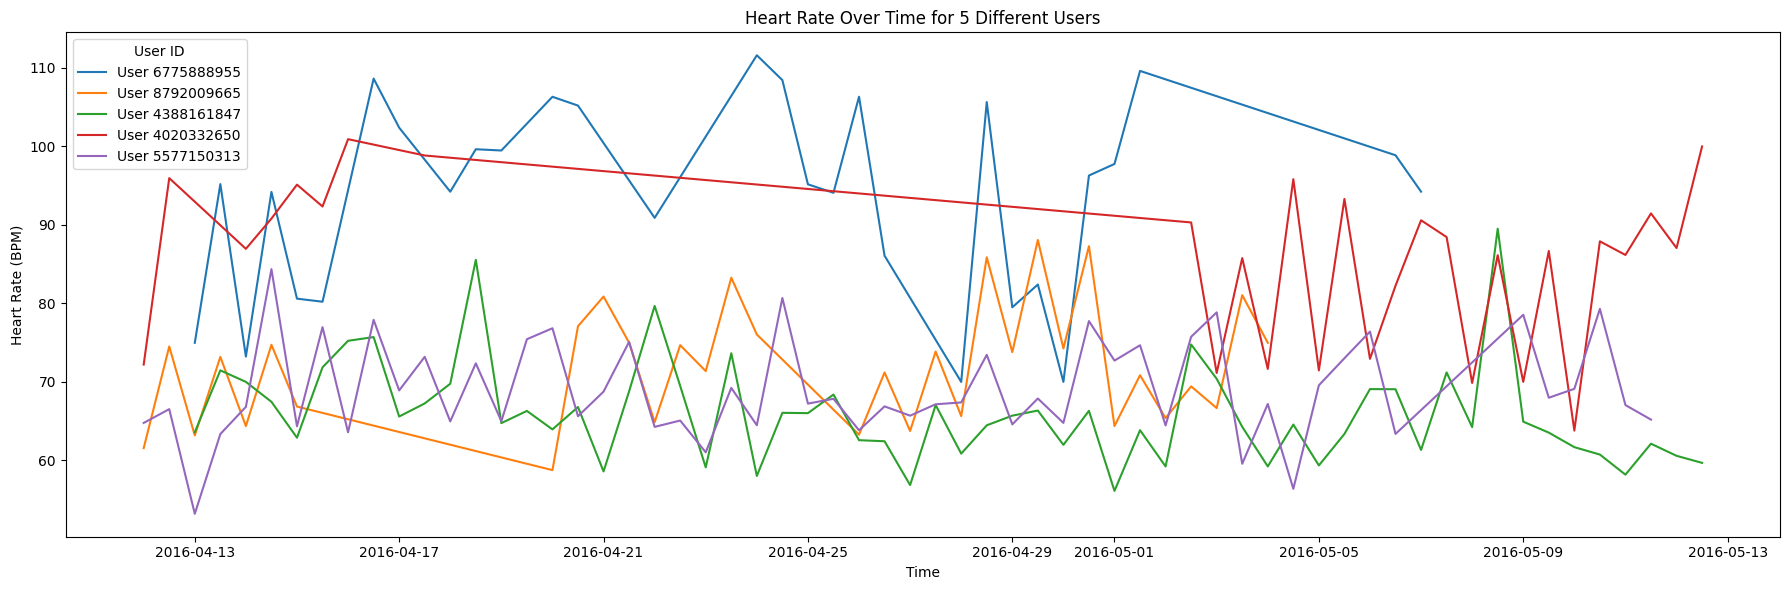

In [7]:
# 1(a) heart rate for 5 different users (user determined by ID)

heart_rate_grouped = heart_rate.groupby("Id")
user_ids = list(heart_rate_grouped.groups.keys())
# select 5 random unique users
np.random.seed(57)
selected_users = np.random.choice(user_ids, 5, replace = False)

# convert time column to datetime
heart_rate["Time"] = pd.to_datetime(heart_rate["Time"])

# find the selected users in the heart_rate_grouped data
heart_rate_subset = heart_rate[heart_rate["Id"].isin(selected_users)]

# downsample the subset to 12 hour intervals by averaging
heart_rate_subset = (
    heart_rate_subset
    .groupby(["Id", pd.Grouper(key="Time", freq="12h")])["Value"] # groups of data for each user in 12H timeframes
    .mean() # takes the mean of the heart rate in the 12H timeframe
    .reset_index()
)

# display(heart_rate_subset)
# print("Selected User IDs:", sorted(selected_users))

# plotting the users' heart rates
plt.figure(figsize=(18,6))
for id in selected_users:
  user_data = heart_rate_subset[heart_rate_subset["Id"] == id]
  plt.plot(user_data["Time"], user_data["Value"], label=f"User {id}")

plt.title("Heart Rate Over Time for 5 Different Users")
plt.xlabel("Time")
plt.ylabel("Heart Rate (BPM)")
plt.legend(title = "User ID")
plt.tight_layout()
plt.show()

/var/folders/m8/81ptgb3x7j755glt7xp0jptc0000gn/T/ipykernel_35167/3159212640.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


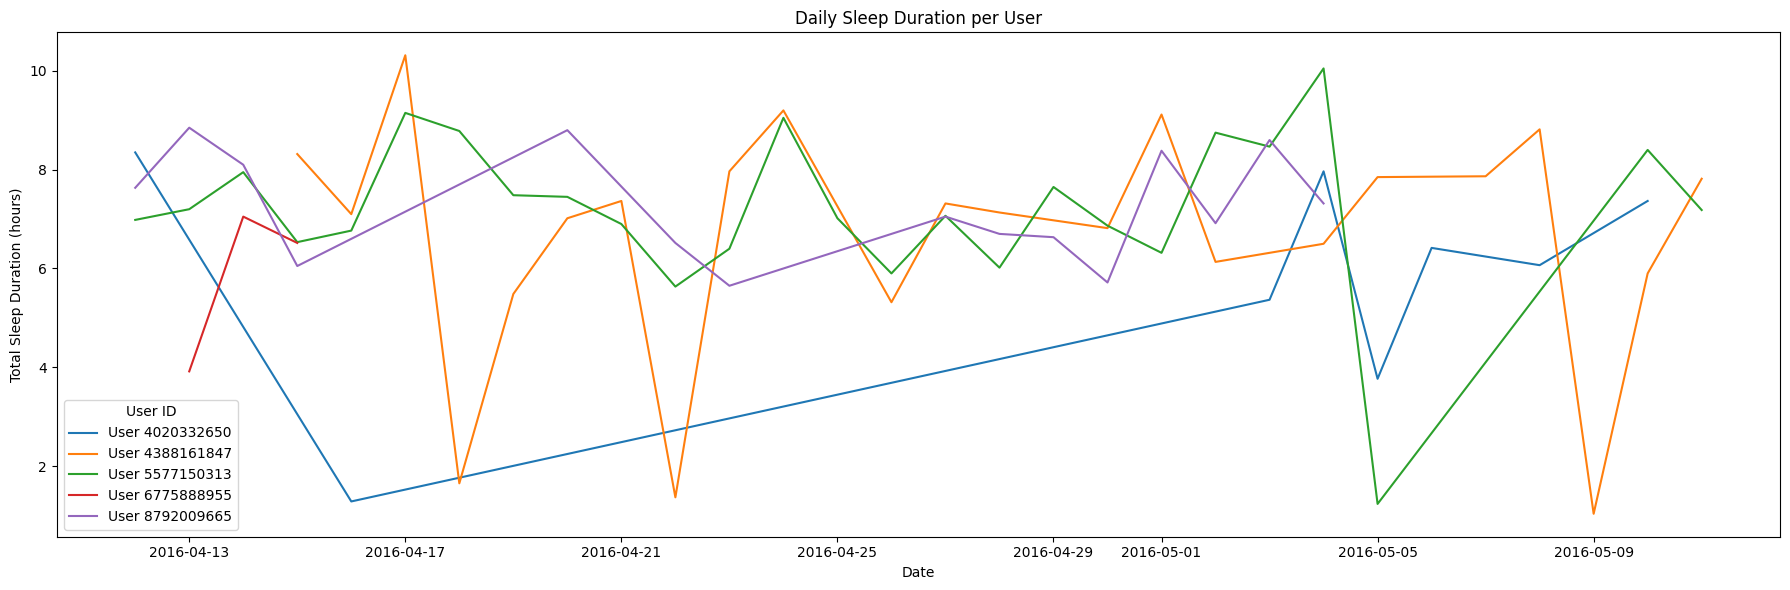

In [8]:
# 1(b) daily sleep duration for 5 different users
# utilizing same 5 selected users in part 1(a)

# convert SleepDay field to datetime
sleep_duration["SleepDay"] = pd.to_datetime(sleep_duration["SleepDay"])

# convert minutes to hours
sleep_duration["TotalHoursAsleep"] = sleep_duration["TotalMinutesAsleep"] / 60
sleep_duration["TotalHoursInBed"] = sleep_duration["TotalTimeInBed"] / 60

# finds the selected users in the sleep_duration_grouped data
sleep_duration_subset = sleep_duration[sleep_duration["Id"].isin(selected_users)]
sleep_duration_grouped = sleep_duration_subset.groupby("Id")

# plot daily sleep durations
plt.figure(figsize=(18, 6))
for user_id, user_data in sleep_duration_grouped:
    plt.plot(user_data["SleepDay"], user_data["TotalHoursAsleep"], label=f"User {user_id}")

# Customize plot
plt.title("Daily Sleep Duration per User")
plt.xlabel("Date")
plt.ylabel("Total Sleep Duration (hours)")
plt.legend(title="User ID")
plt.tight_layout()
plt.show()

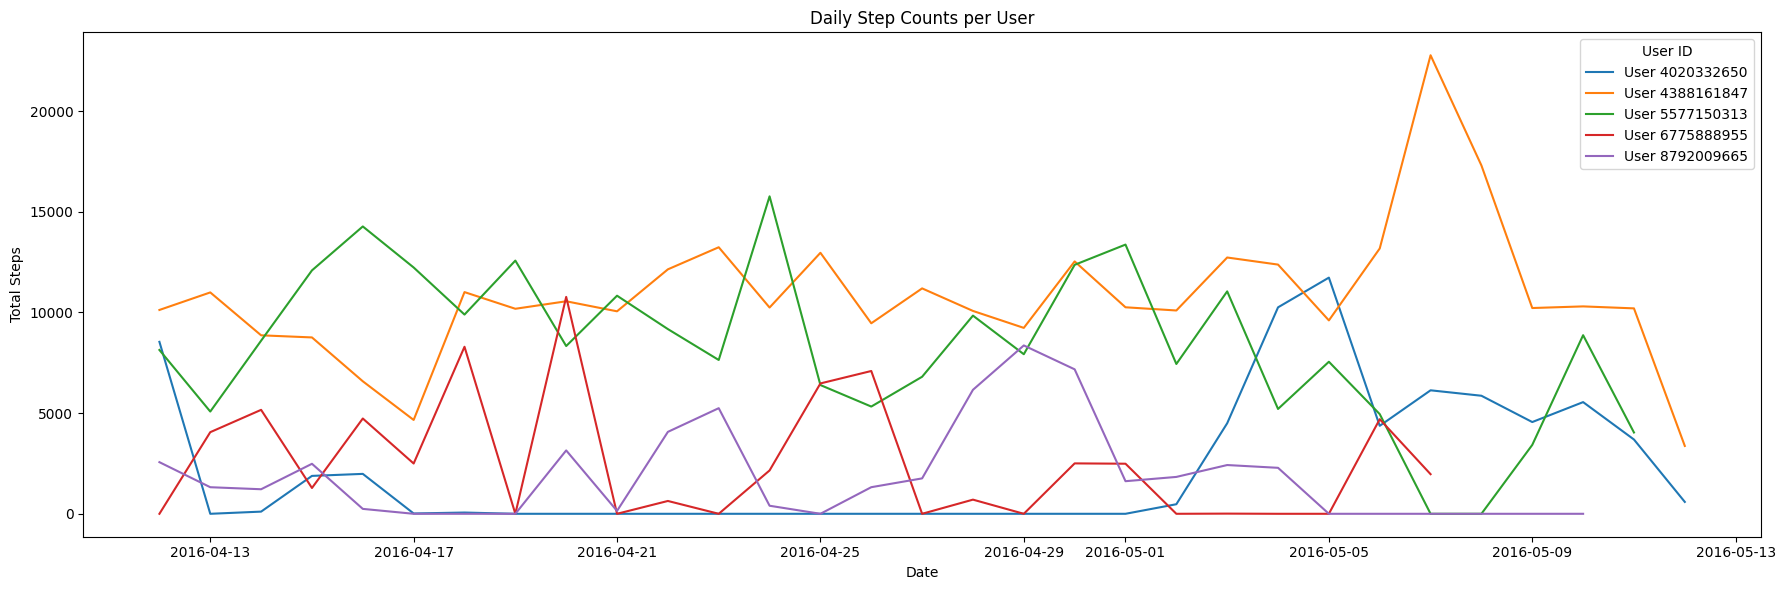

In [9]:
# 1(c) daily steps for 5 different users
# utilizing same 5 selected users in part 1(a)

# convert ActivityDay to datetime
daily_steps["ActivityDay"] = pd.to_datetime(daily_steps["ActivityDay"])

# finds the selected users in the daily_steps data
daily_steps_subset = daily_steps[daily_steps["Id"].isin(selected_users)]
daily_steps_grouped = daily_steps_subset.groupby("Id")

# plot daily steps for the 5 users
plt.figure(figsize=(18,6))

for user_id, user_data in daily_steps_grouped:
  plt.plot(user_data["ActivityDay"], user_data["StepTotal"], label=f"User {user_id}")

plt.title("Daily Step Counts per User")
plt.xlabel("Date")
plt.ylabel("Total Steps")
plt.legend(title="User ID")
plt.tight_layout()
plt.show()

/var/folders/m8/81ptgb3x7j755glt7xp0jptc0000gn/T/ipykernel_35167/2066901589.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


6962181067


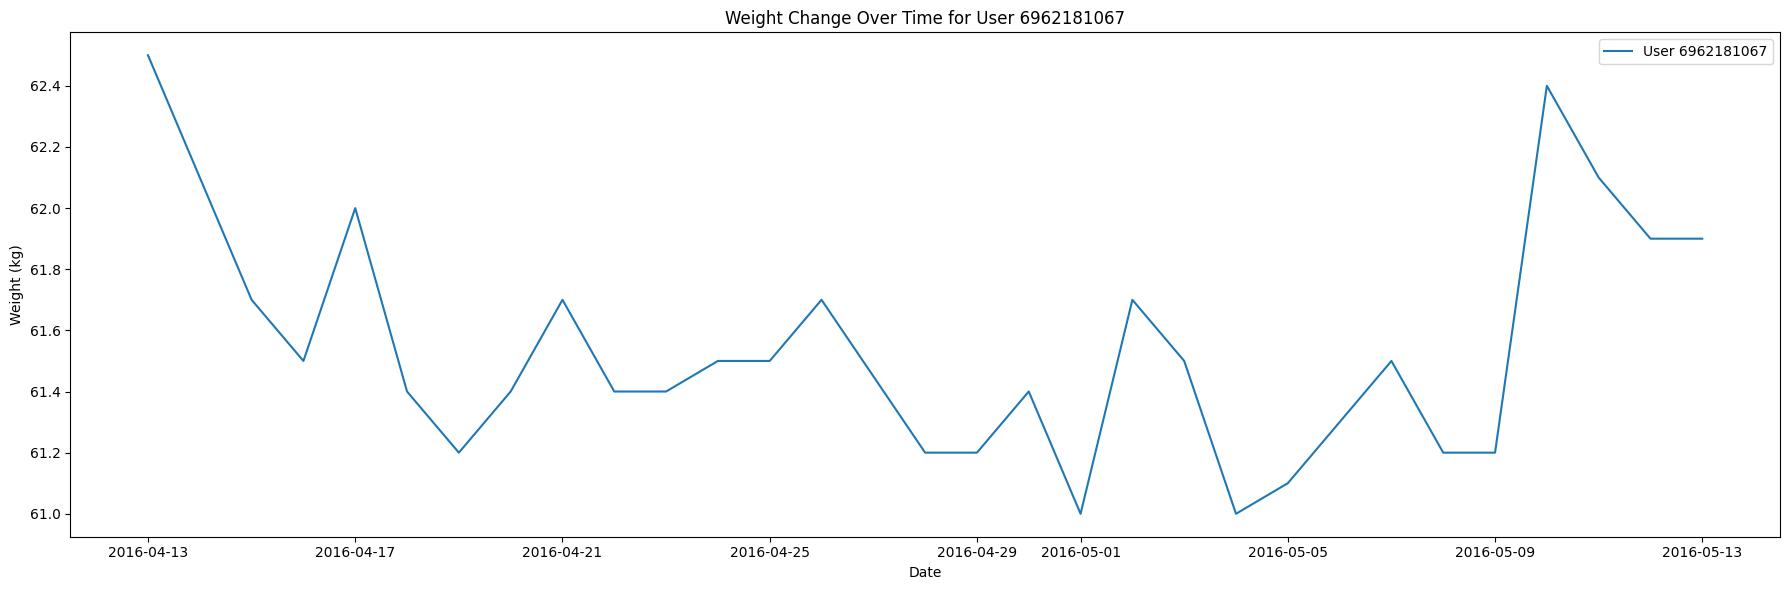

In [10]:
# 1(d) weight change of the user with the highest number of weight recorded
# converting Date to datetime

weight_change["Date"] = pd.to_datetime(weight_change["Date"])

# find user with highest number of weight records
top_user_id = weight_change["Id"].value_counts().idxmax()
print(top_user_id)

# obtain the top_user's data
top_user_data = weight_change[weight_change["Id"] == top_user_id]

# plot weight change for the top user
plt.figure(figsize=(18,6))
plt.plot(top_user_data["Date"], top_user_data["WeightKg"], label=f"User {top_user_id}")

plt.title(f"Weight Change Over Time for User {top_user_id}")
plt.xlabel("Date")
plt.ylabel("Weight (kg)")
plt.legend()
plt.tight_layout()
plt.show()

# 2. Data Processing

In [11]:
# 2(a) Create dataframes merging information from multiple datasets

#####
# HOURLY
#####
hour_step = pd.read_csv("./fitabase-data/hourlySteps_merged.csv")
hour_intensity = pd.read_csv("./fitabase-data/hourlyIntensities_merged.csv")
hour_calories = pd.read_csv("./fitabase-data/hourlyCalories_merged.csv")

hour_step_intensity = hour_step.merge(hour_intensity, on=["Id", "ActivityHour"])
hourly_merged = hour_step_intensity.merge(hour_calories, on=["Id", "ActivityHour"])

# display(hourly_merged)

#####
# MINUTELY
#####
min_calories = pd.read_csv("./fitabase-data/minuteCaloriesNarrow_merged.csv")
min_intensity = pd.read_csv("./fitabase-data/minuteIntensitiesNarrow_merged.csv")
min_mets = pd.read_csv("./fitabase-data/minuteMETsNarrow_merged.csv")

min_calories_intensity = min_calories.merge(min_intensity, on=["Id", "ActivityMinute"])
minutely_merged = min_calories_intensity.merge(min_mets, on=["Id", "ActivityMinute"])

# display(minutely_merged)

In [12]:
# 2(b) Convert time strings to datetime type

daily_activity = pd.read_csv("./fitabase-data/dailyActivity_merged.csv")
sleep_day = pd.read_csv("./fitabase-data/sleepDay_merged.csv")

# daily activity to datetime
daily_activity["Date"] = pd.to_datetime(daily_activity["ActivityDate"])

# sleep day data to datetime
sleep_day["Date"] = pd.to_datetime(sleep_day["SleepDay"])

# hourly merged to datetime
hourly_merged["Date"] = pd.to_datetime(hourly_merged["ActivityHour"])

# minutely merged to datetime
minutely_merged["Date"] = pd.to_datetime(minutely_merged["ActivityMinute"])

# quick look
# display(daily_activity.head())
# display(sleep_day.head())
# display(hourly_merged.head())
# display(minutely_merged.head())

/var/folders/m8/81ptgb3x7j755glt7xp0jptc0000gn/T/ipykernel_35167/2435088514.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
/var/folders/m8/81ptgb3x7j755glt7xp0jptc0000gn/T/ipykernel_35167/2435088514.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
/var/folders/m8/81ptgb3x7j755glt7xp0jptc0000gn/T/ipykernel_35167/2435088514.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


In [14]:
# 2(c) Process heart rate data

heart_rate_seconds = pd.read_csv("./fitabase-data/heartrate_seconds_merged.csv")

# convert Time to datetime
heart_rate_seconds["Time"] = pd.to_datetime(heart_rate_seconds["Time"])
# floor to nearest minute
heart_rate_seconds["Date"] = heart_rate_seconds["Time"].dt.floor("T")

# calculate avg heart rate per min per user
# group by Id and Date operate on Value
target_grouped = heart_rate_seconds.groupby(["Id", "Date"])["Value"]
target_grouped_mean = target_grouped.mean()
# reset indices and rename
hr_per_min = target_grouped_mean.reset_index()
hr_per_min = hr_per_min.rename(columns={"Value": "hr_per_min"})

# update Date to match
minutely_merged["Date"] = pd.to_datetime(minutely_merged["Date"]).dt.floor("T")
# add as new column in minutely dataframe
minutely_with_hr = minutely_merged.merge(hr_per_min, on=["Id", "Date"], how="left")

# display(minutely_merged.head())
# display(minutely_merged.tail())


/var/folders/m8/81ptgb3x7j755glt7xp0jptc0000gn/T/ipykernel_35167/404792476.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
/var/folders/m8/81ptgb3x7j755glt7xp0jptc0000gn/T/ipykernel_35167/404792476.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.


# 3. Correlation and Plots

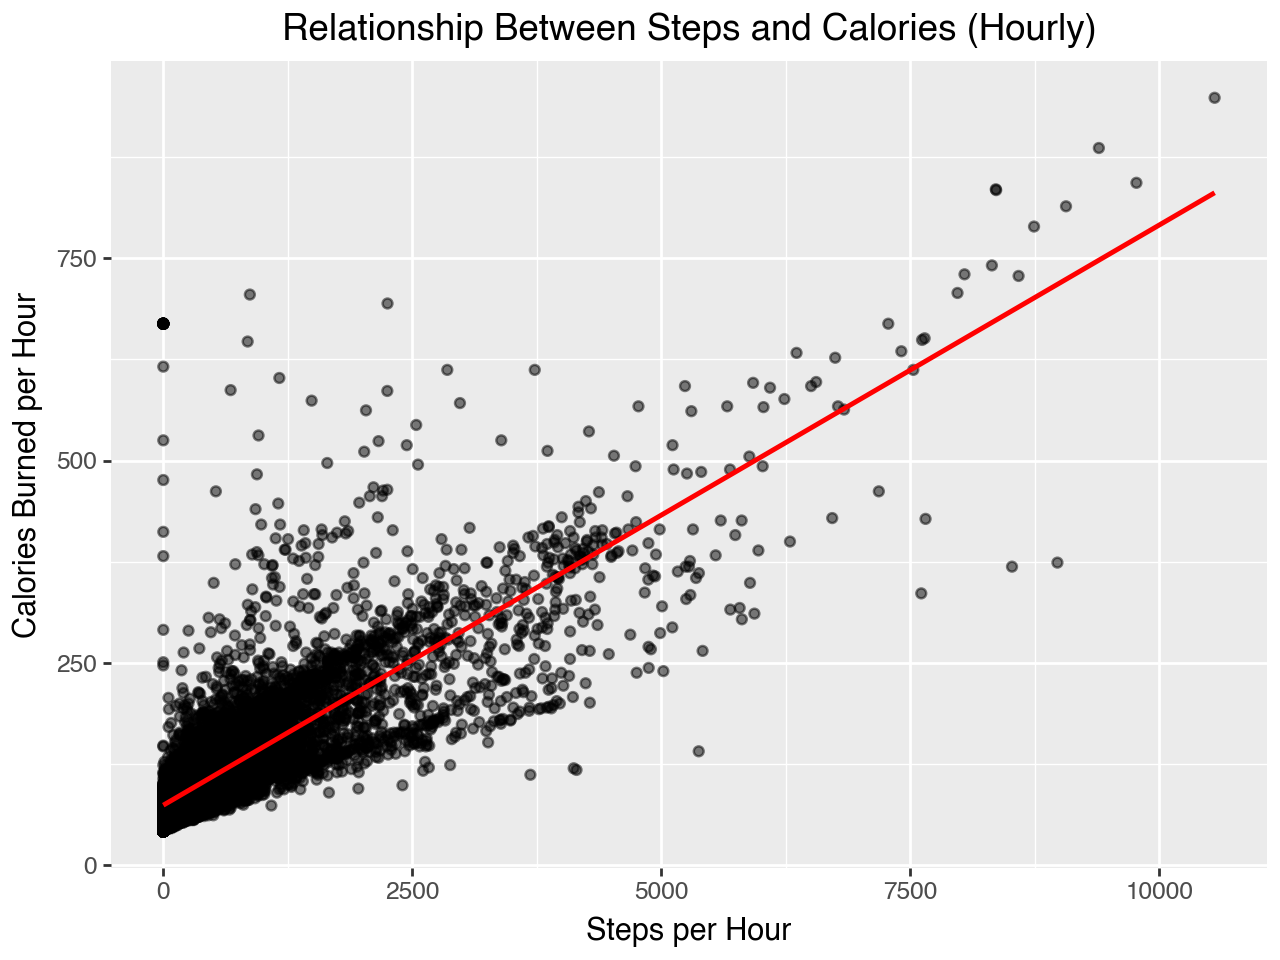

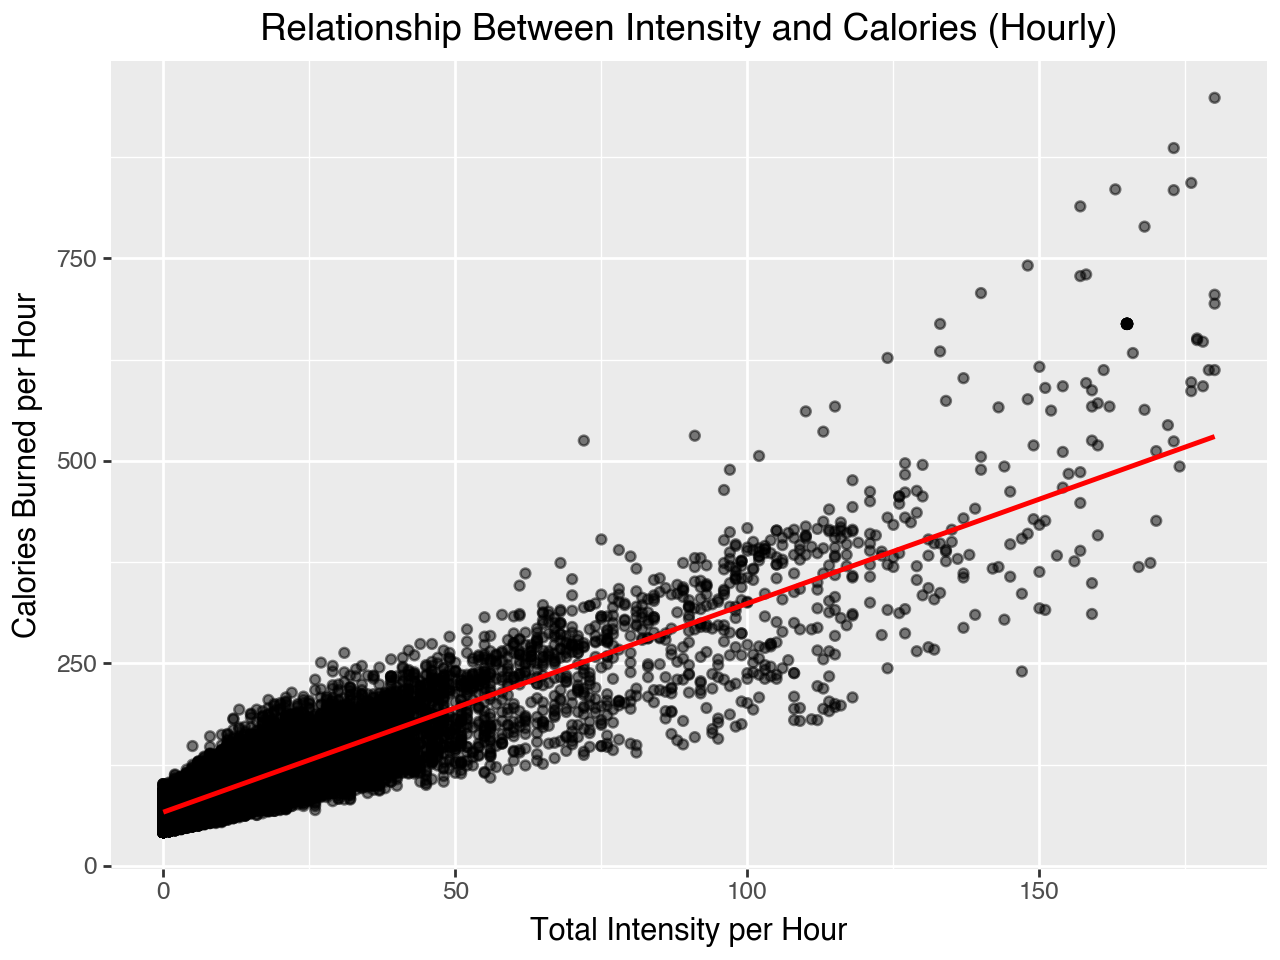

In [27]:
# 3(a) use hourly datasets to create scatterplots showing relationship between...
#####
# Steps and Calories
#####

steps_vs_calories = (
  ggplot(hourly_merged, aes(x="StepTotal", y="Calories")) + 
  geom_point(alpha = 0.5) + 
  geom_smooth(method="lm", color="red", se=False) + 
  labs(title="Relationship Between Steps and Calories (Hourly)",
       x = "Steps per Hour",
       y = "Calories Burned per Hour")
)

display(steps_vs_calories)

#####
# Intensity and Calories
#####
intensity_vs_calories = (
  ggplot(hourly_merged, aes(x = "TotalIntensity", y="Calories")) + 
  geom_point(alpha = 0.5) + 
  geom_smooth(method="lm", color="red", se=False) + 
  labs(title="Relationship Between Intensity and Calories (Hourly)",
       x = "Total Intensity per Hour",
       y = "Calories Burned per Hour")
)

display(intensity_vs_calories)

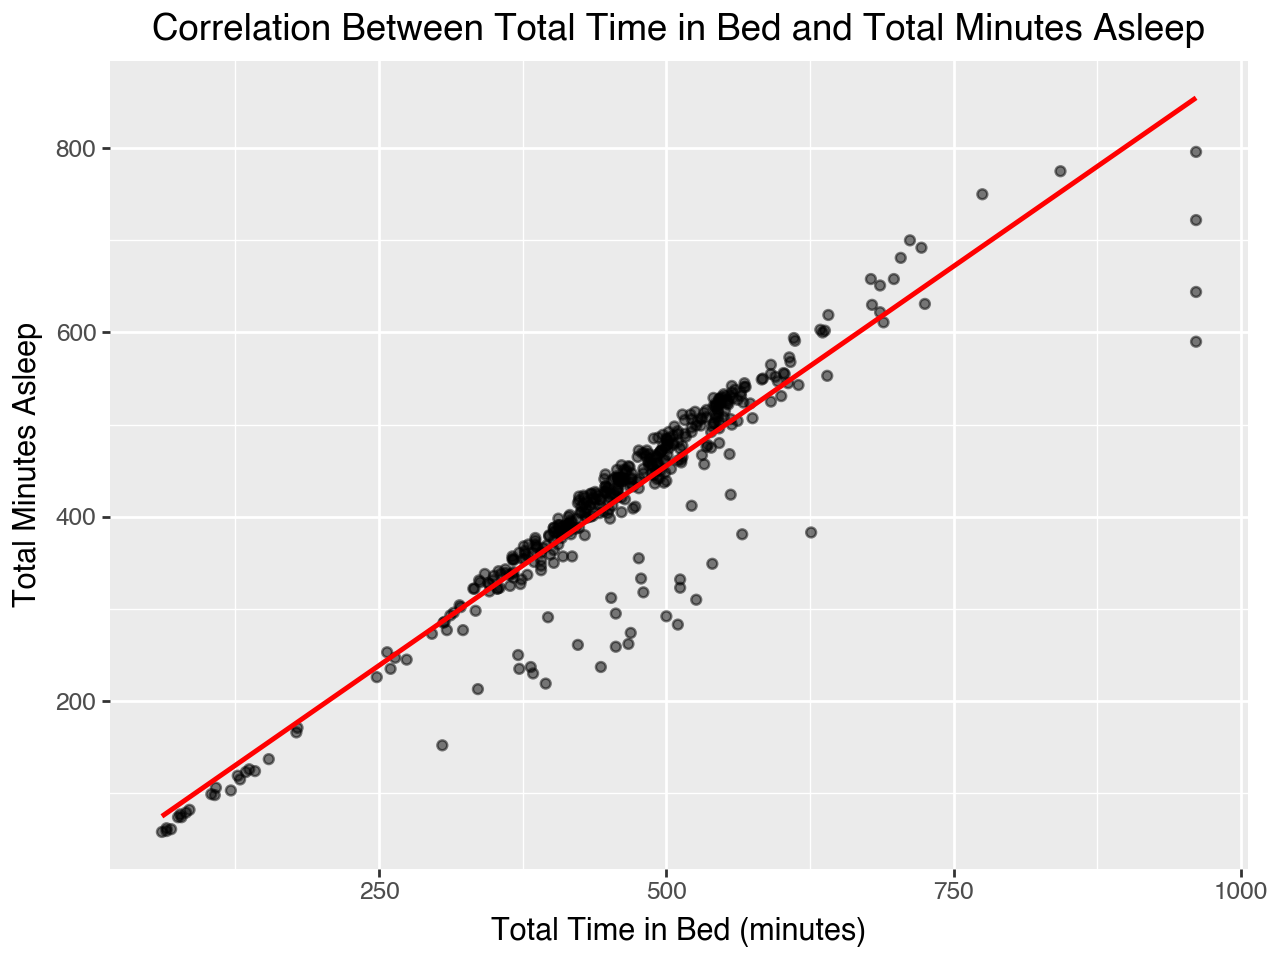

In [30]:
# 3(b) Create a scatterplot to show correlation between TotalMinutesAsleep
# and TotalTimeInBed

#display(sleep_duration)

asleep_vs_inbed = (
  ggplot(sleep_duration, aes(x="TotalTimeInBed", y ="TotalMinutesAsleep")) +
  geom_point(alpha=0.5) +
  geom_smooth(method="lm", color="red", se=False) + 
  labs(title="Correlation Between Total Time in Bed and Total Minutes Asleep",
       x = "Total Time in Bed (minutes)",
       y = "Total Minutes Asleep")
)

display(asleep_vs_inbed)

,Id,ActivityHour,StepTotal,TotalIntensity,AverageIntensity,Calories,Date
0,1503960366,4/12/2016 12:00:00 AM,373,20,0.333333,81,2016-04-12 00:00:00
1,1503960366,4/12/2016 1:00:00 AM,160,8,0.133333,61,2016-04-12 01:00:00
2,1503960366,4/12/2016 2:00:00 AM,151,7,0.116667,59,2016-04-12 02:00:00
3,1503960366,4/12/2016 3:00:00 AM,0,0,0.000000,47,2016-04-12 03:00:00
4,1503960366,4/12/2016 4:00:00 AM,0,0,0.000000,48,2016-04-12 04:00:00
...,...,...,...,...,...,...,...
22094,8877689391,5/12/2016 10:00:00 AM,514,12,0.200000,126,2016-05-12 10:00:00
22095,8877689391,5/12/2016 11:00:00 AM,1407,29,0.483333,192,2016-05-12 11:00:00
22096,8877689391,5/12/2016 12:00:00 PM,3135,93,1.550000,321,2016-05-12 12:00:00
22097,8877689391,5/12/2016 1:00:00 PM,307,6,0.100000,101,2016-05-12 13:00:00


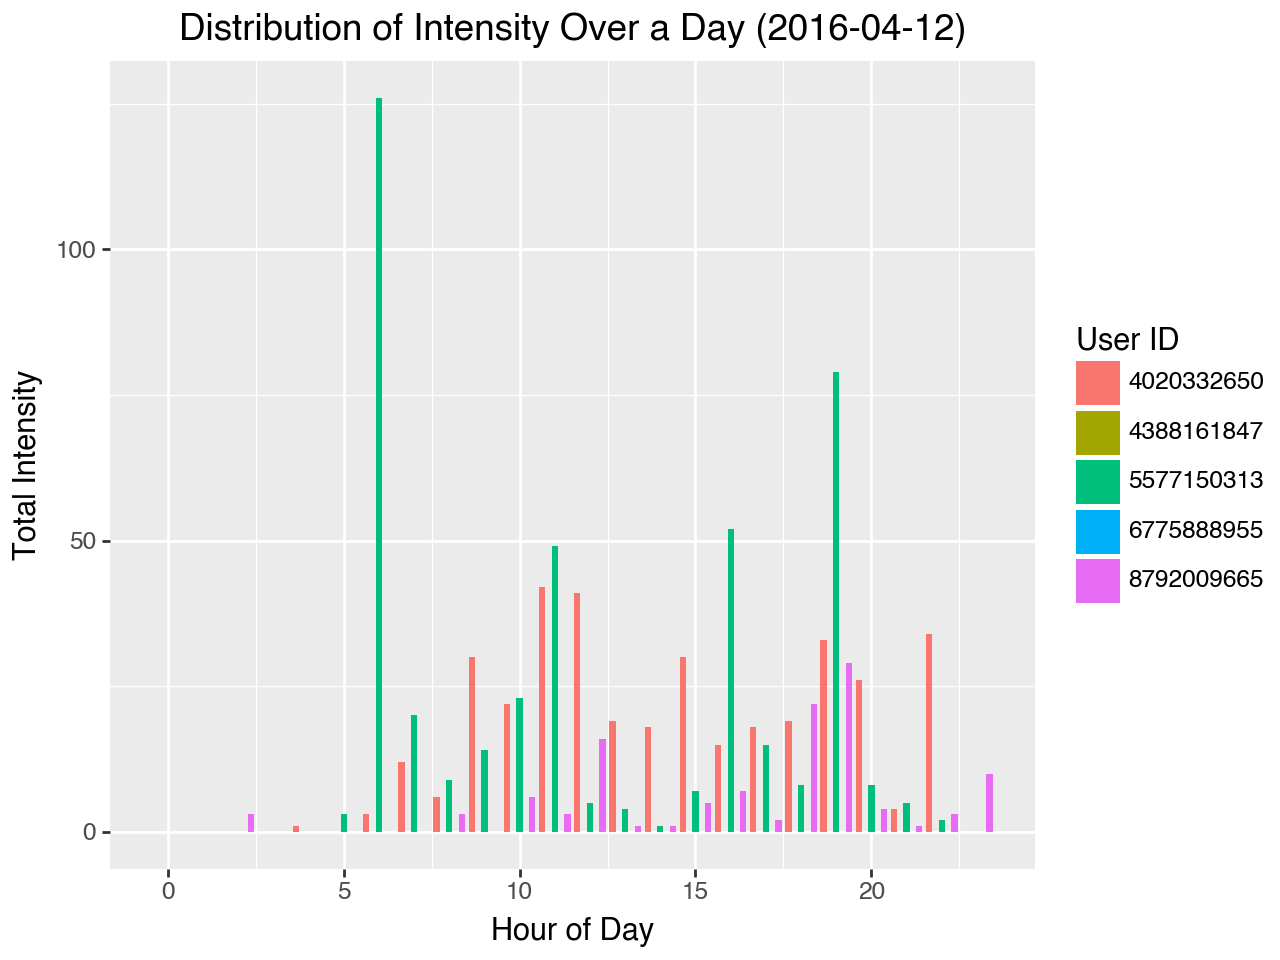

In [45]:
# 3(c) plotting bar graphs displaying the distribution of intensity over a day

display(hourly_merged)

# select date for hourly data
selected_day = pd.to_datetime("2016-04-12")
# filter data for the date
hourly_day = hourly_merged[hourly_merged["Date"].dt.date == selected_day.date()]

# too many users... using the randomly selected few from above
hourly_day = hourly_day[hourly_day["Id"].isin(selected_users)]
# extract hour of day
hourly_day["Hour"] = hourly_day["Date"].dt.hour

# group by user and day
grouped_subset = hourly_day.groupby(["Id", "Hour"])["TotalIntensity"]
# calculate daily intensities
hourly_intensity = grouped_subset.sum()
hourly_intensity = hourly_intensity.reset_index()

intensity_over_day = (
  ggplot(hourly_intensity, aes(x="Hour", y="TotalIntensity", fill="factor(Id)")) +
  geom_bar(stat="identity", position="dodge") +
  labs(
      title=f"Distribution of Intensity Over a Day ({selected_day.date()})",
      x="Hour of Day",
      y="Total Intensity",
      fill="User ID"
  )
)

display(intensity_over_day)

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,Date,TotalMinutesAsleep
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985,2016-04-12,327
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797,2016-04-13,384
2,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745,2016-04-15,412
3,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863,2016-04-16,340
4,1503960366,4/17/2016,9705,6.48,6.48,0.0,3.19,0.78,2.51,0.0,38,20,164,539,1728,2016-04-17,700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,8792009665,4/30/2016,7174,4.59,4.59,0.0,0.33,0.36,3.91,0.0,10,20,301,749,2896,2016-04-30,343
409,8792009665,5/1/2016,1619,1.04,1.04,0.0,0.00,0.00,1.04,0.0,0,0,79,834,1962,2016-05-01,503
410,8792009665,5/2/2016,1831,1.17,1.17,0.0,0.00,0.00,1.17,0.0,0,0,101,916,2015,2016-05-02,415
411,8792009665,5/3/2016,2421,1.55,1.55,0.0,0.00,0.00,1.55,0.0,0,0,156,739,2297,2016-05-03,516


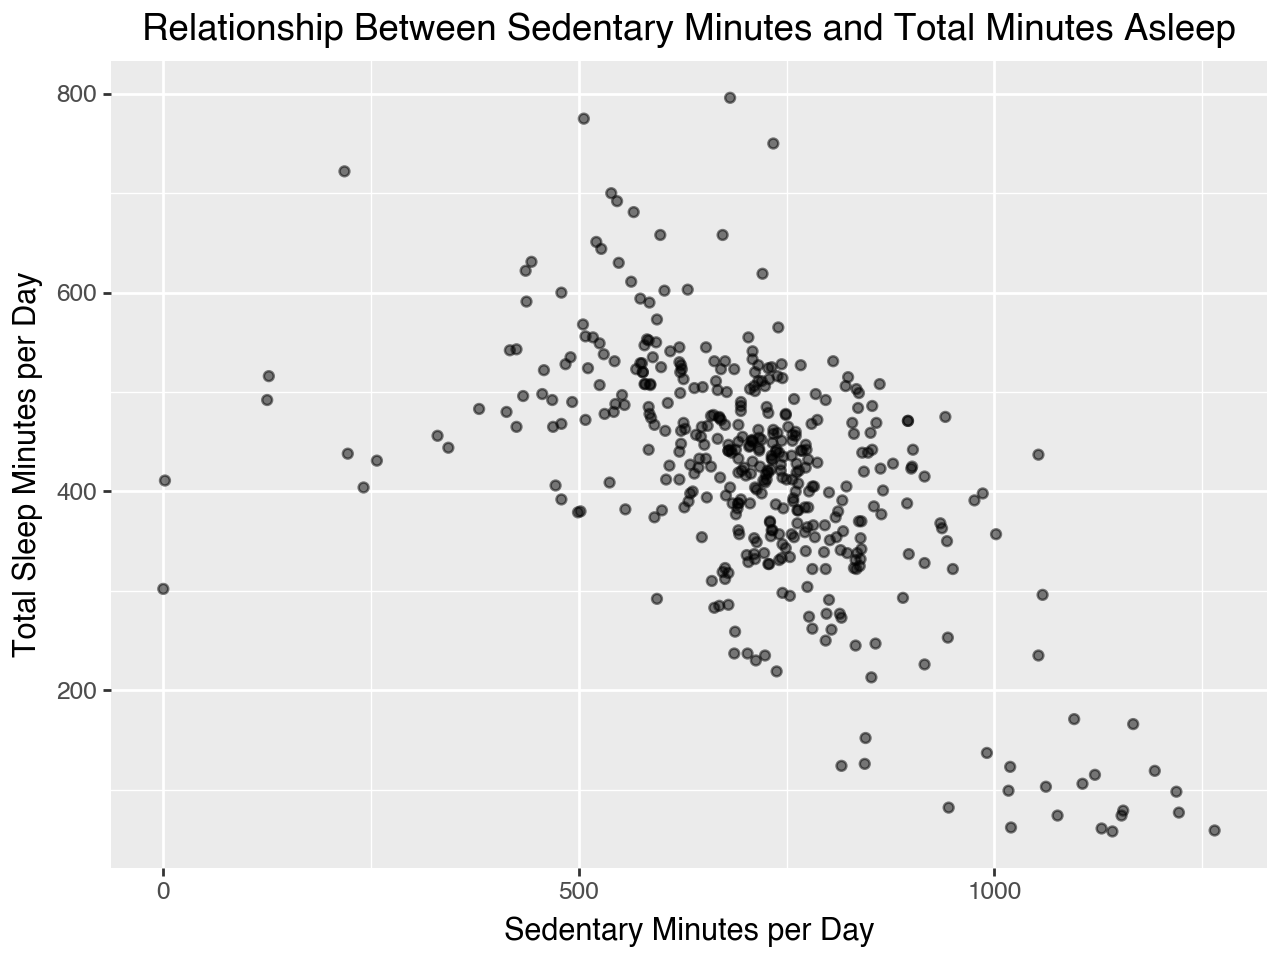

In [58]:
# 3(d) create a scatterplot showing the relationship between 
# TotalMinutesAsleep and SedentaryMinutes.

daily_activity = pd.read_csv("./fitabase-data/dailyActivity_merged.csv")
# convert Date to datetime
daily_activity["Date"] = pd.to_datetime(daily_activity["ActivityDate"])
# add column that converts SleepDay to datetime Date
sleep_duration["Date"] = pd.to_datetime(sleep_duration["SleepDay"])

# merge with sleep data
sleep_activity_merged = pd.merge(daily_activity,
                                 sleep_duration[["Id", "Date", "TotalMinutesAsleep"]],
                                 on=["Id", "Date"],
                                 how="inner")
display(sleep_activity_merged)

sleep_vs_sedentary = (
  ggplot(sleep_activity_merged, aes(x="SedentaryMinutes", y="TotalMinutesAsleep")) + 
  geom_point(alpha = 0.5) +
  labs(title="Relationship Between Sedentary Minutes and Total Minutes Asleep",
       x = "Sedentary Minutes per Day",
       y = "Total Sleep Minutes per Day")
)

display(sleep_vs_sedentary)

# 4. T-tests

In [71]:
#####
# Variable One: Most significant differences for calories: TotalMinutesAsleep
# H0 = No difference in calories between users who sleep more and users who sleep less
#####

# convert dates to datetime... if not already
daily_activity["Date"] = pd.to_datetime(daily_activity["ActivityDate"])
sleep_duration["Date"] = pd.to_datetime(sleep_duration["SleepDay"]).dt.floor('d')

# merge daily activity and sleep duration for Calories and TotalMinutesAsleep
merged_data = pd.merge(daily_activity,
                       sleep_duration[["Id", "Date", "TotalMinutesAsleep"]],
                       on=["Id", "Date"])

# split by median
median_sleep = merged_data["TotalMinutesAsleep"].median()
low_sleep = merged_data[merged_data["TotalMinutesAsleep"] <= median_sleep]["Calories"]
high_sleep = merged_data[merged_data["TotalMinutesAsleep"] > median_sleep]["Calories"]

# run two-sample t-test
sleep_t_stat, sleep_p_value = ttest_ind(high_sleep, low_sleep, equal_var=False)
print("T-test for Calories by Sleep Amount")
print("-" * 30)
print("t-statistic:", sleep_t_stat)
print(f"p-value: {sleep_p_value} \n\n")

'''
WAS NOT SIGNIFICANT...
'''

#####
# Variable One': Most significant differences for calories: VeryActiveMinutes
# H0 = No difference in calories between users who are very active and less active
#####

# split users by median
median_active = daily_activity["VeryActiveMinutes"].median()
low_active = daily_activity[daily_activity["VeryActiveMinutes"] <= median_active]["Calories"]
high_active = daily_activity[daily_activity["VeryActiveMinutes"] > median_active]["Calories"]

# perform two-sample t-test
active_t_stat, active_p_value = ttest_ind(high_active, low_active, equal_var=False)

print("T-test for Calories by Activity Level")
print("-" * 30)
print("t-statistic:", active_t_stat)
print(f"p-value: {active_p_value} \n")

#####
# Variable Two: Least significant different for calories: DayOfWeek
# H0 = No difference in calories depending on the day of the week (Monday or Tuesday)
#####

# add column for day of week
daily_activity["DayOfWeek"] = daily_activity["Date"].dt.day_name()

# obtain calories for monday and tuesday
monday_cal = daily_activity[daily_activity["DayOfWeek"] == "Monday"]["Calories"]
tuesday_cal = daily_activity[daily_activity["DayOfWeek"] == "Tuesday"]["Calories"]

# perform two-sample t-test
day_t_stat, day_p_value = ttest_ind(monday_cal, tuesday_cal, equal_var=False)

print("\nT-test for Calories by Day of Week (Monday vs Tuesday)")
print("-" * 30)
print("t-statistic:", day_t_stat)
print("p-value:", day_p_value)


T-test for Calories by Sleep Amount
------------------------------
t-statistic: -1.1730939382735088
p-value: 0.24143755614117346 


T-test for Calories by Activity Level
------------------------------
t-statistic: 15.421060605509052
p-value: 1.169113266463641e-47 


T-test for Calories by Day of Week (Monday vs Tuesday)
------------------------------
t-statistic: -0.3894130705239999
p-value: 0.6972824372699242


/var/folders/m8/81ptgb3x7j755glt7xp0jptc0000gn/T/ipykernel_35167/3143934105.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
